In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

random_seed = 6

In [23]:
data_dir = Path.cwd().parent / "data"

In [24]:
features_df = pd.read_csv(data_dir / "training_set_features.csv",index_col = 0)
labels_df = pd.read_csv(data_dir / "training_set_labels.csv", index_col = 0)
print("features_df", features_df.shape)
features_df

features_df (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [25]:
features_df.dtypes != "object"

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
r

In [26]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [27]:
numeric_preprocessins_steps = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("simple_imputer", SimpleImputer(strategy="median")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_preprocessins_steps, numeric_cols)],
    remainder="drop",
)

In [28]:
estimators = MultiOutputClassifier(estimator=LogisticRegression(penalty="l2", C=1))

In [29]:
full_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("estimator", estimators),
    ]
)

In [30]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'], dtype=object))])),
                ('estimator',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size = 0.3,
    shuffle = True,
    stratify = labels_df,
    random_state = random_seed,
)

In [32]:
%%time

full_pipeline.fit(X_train, y_train)

preds = full_pipeline.predict_proba(X_test)
preds

CPU times: total: 141 ms
Wall time: 261 ms


[array([[0.94086093, 0.05913907],
        [0.97956884, 0.02043116],
        [0.91871113, 0.08128887],
        ...,
        [0.91579842, 0.08420158],
        [0.4385822 , 0.5614178 ],
        [0.60083173, 0.39916827]]),
 array([[0.15508522, 0.84491478],
        [0.95094353, 0.04905647],
        [0.61780679, 0.38219321],
        ...,
        [0.85865557, 0.14134443],
        [0.09847948, 0.90152052],
        [0.90625723, 0.09374277]])]

In [33]:
print("test_probas[0].shape:", preds[0].shape)
print("test_probas[1].shape:", preds[1].shape)

test_probas[0].shape: (8013, 2)
test_probas[1].shape: (8013, 2)


In [34]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_test.index,

)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8013, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26034,0.059139,0.844915
626,0.020431,0.049056
13813,0.081289,0.382193
2500,0.572461,0.784640
13170,0.034872,0.687124


In [35]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color = "grey", linestyle = "--")
    ax.set_ylabel("TPR")
    ax.set_xlabel("FPR")
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

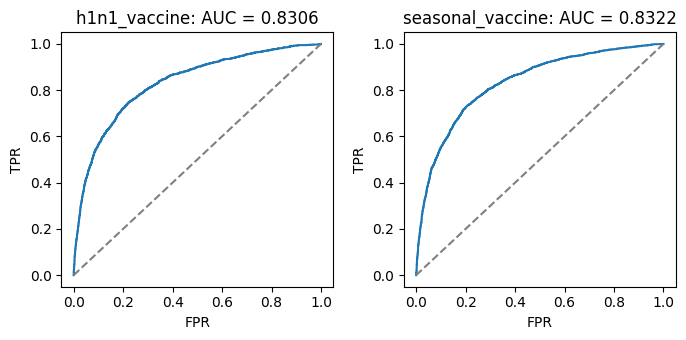

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3.5))

plot_roc(y_test["h1n1_vaccine"], y_preds["h1n1_vaccine"], "h1n1_vaccine", ax[0])
plot_roc(y_test["seasonal_vaccine"], y_preds["seasonal_vaccine"], "seasonal_vaccine", ax[1])

fig.tight_layout()

In [37]:
roc_auc_score(y_test, y_preds)

np.float64(0.831417691344742)

In [38]:
%%time

full_pipeline.fit(features_df, labels_df)

None

CPU times: total: 297 ms
Wall time: 178 ms


In [39]:
test_features_df = pd.read_csv(data_dir / "test_set_features.csv", index_col = 0)
test_features_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [40]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.87283819, 0.12716181],
        [0.94481184, 0.05518816],
        [0.62897566, 0.37102434],
        ...,
        [0.80407916, 0.19592084],
        [0.94923908, 0.05076092],
        [0.38449839, 0.61550161]]),
 array([[0.57376944, 0.42623056],
        [0.92878998, 0.07121002],
        [0.3625742 , 0.6374258 ],
        ...,
        [0.59853519, 0.40146481],
        [0.67993994, 0.32006006],
        [0.35775603, 0.64224397]])]

In [41]:
submission_df = pd.read_csv(data_dir / "submission_format.csv", index_col = 0)
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [42]:
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.127162,0.426231
26708,0.055188,0.071210
26709,0.371024,0.637426
26710,0.464154,0.803612
26711,0.286619,0.634788
